In [1]:
from catboost import CatBoostRanker, Pool, MetricVisualizer
import matplotlib.pyplot as plt
from collections import Counter
from math import ceil
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np
import os
import pandas as pd
from utils import *

In [2]:
df = pd.read_csv('intern_task.csv')
df = sort_df(df)
df

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.0,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,2,10,3.0,3.0,3.0,1.0,3.0,1.000000,1.0,1.000000,...,0.0,0.0,0.142857,0.998020,22.936731,0.333333,0.022648,0.000009,31.0,10.333333
2,0,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,2,10,3.0,0.0,0.0,0.0,3.0,1.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.997559,0.000000,0.000000,0.010774,0.000001,16.0,5.333333
4,1,10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,1,29995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
235254,1,29995,1.0,1.0,1.0,1.0,1.0,0.500000,0.5,0.500000,...,0.0,0.0,0.111111,0.471409,13.302685,0.500000,0.019608,0.000037,1.0,0.500000
235255,2,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.0,0.000000,0.471409,0.000000,0.000000,0.003916,0.000017,3.0,1.500000
235256,1,29995,1.0,0.0,0.0,0.0,1.0,0.500000,0.0,0.000000,...,0.0,0.0,0.000000,0.471409,0.000000,0.000000,0.003077,0.000010,4.0,2.000000


In [3]:
df = drop_features(df)

name: feature_64 | item: 0 | dtype: int64
name: feature_65 | item: 0 | dtype: int64
name: feature_72 | item: 1 | dtype: int64
name: feature_100 | item: 0 | dtype: int64


In [4]:
df_train, df_test = train_test(df)

In [5]:
df_train = fix_class_dist(df_train)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [6]:
df_train = sort_df(df_train)
df_test = sort_df(df_test)

In [7]:
X_train = df_train.drop(['rank', 'query_id'], axis=1)
X_test = df_test.drop(['rank', 'query_id'], axis=1)

y_train = df_train['rank']
y_test = df_test['rank']

queries_train = df_train['query_id']
queries_test = df_test['query_id']

In [8]:
max_relevance = np.max(y_train)
y_train = y_train / max_relevance
y_test = y_test / max_relevance

In [9]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test
)

In [10]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['NDCG:top=5', 'PFound:top=5', 'AverageGain:top=5'],
    'verbose': False,
    'random_seed': 0,
    'task_type': 'GPU'
}

parameters = {}

In [11]:
def fit_model(loss_function, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool)

    return model

def plot_results(model):
    result = model.get_evals_result()['validation']
    result_val_keys = list(result.keys())
    fig, ax = plt.subplots(2, 3, tight_layout=True, dpi=200, figsize=(20, 10))
    n = 0
    ax[0, n].plot(result[result_val_keys[n]])
    ax[0, n].set_xlabel('iteration')
    ax[0, n].set_ylabel(result_val_keys[n])

    n += 1
    ax[0, n].plot(result[result_val_keys[n]])
    ax[0, n].set_xlabel('iteration')
    ax[0, n].set_ylabel(result_val_keys[n])

    n += 1
    ax[0, n].plot(result[result_val_keys[n]])
    ax[0, n].set_xlabel('iteration')
    ax[0, n].set_ylabel(result_val_keys[n])

    k = 0
    ax[1, k].plot(result[result_val_keys[n + k]])
    ax[1, k].set_xlabel('iteration')
    ax[1, k].set_ylabel(result_val_keys[n + k])

    k += 1
    ax[1, k].plot(result[result_val_keys[n + k]])
    ax[1, k].set_xlabel('iteration')
    ax[1, k].set_ylabel(result_val_keys[n + k])

In [12]:
model = fit_model('RMSE', {'custom_metric': ['NDCG:top=5', 'PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

c:\Users\gorya\OneDrive\Рабочий стол\vk ranking\.venv\lib\site-packages\catboost\core.py:6346: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)
Default metric period is 5 because PrecisionAt, RecallAt, MAP, NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


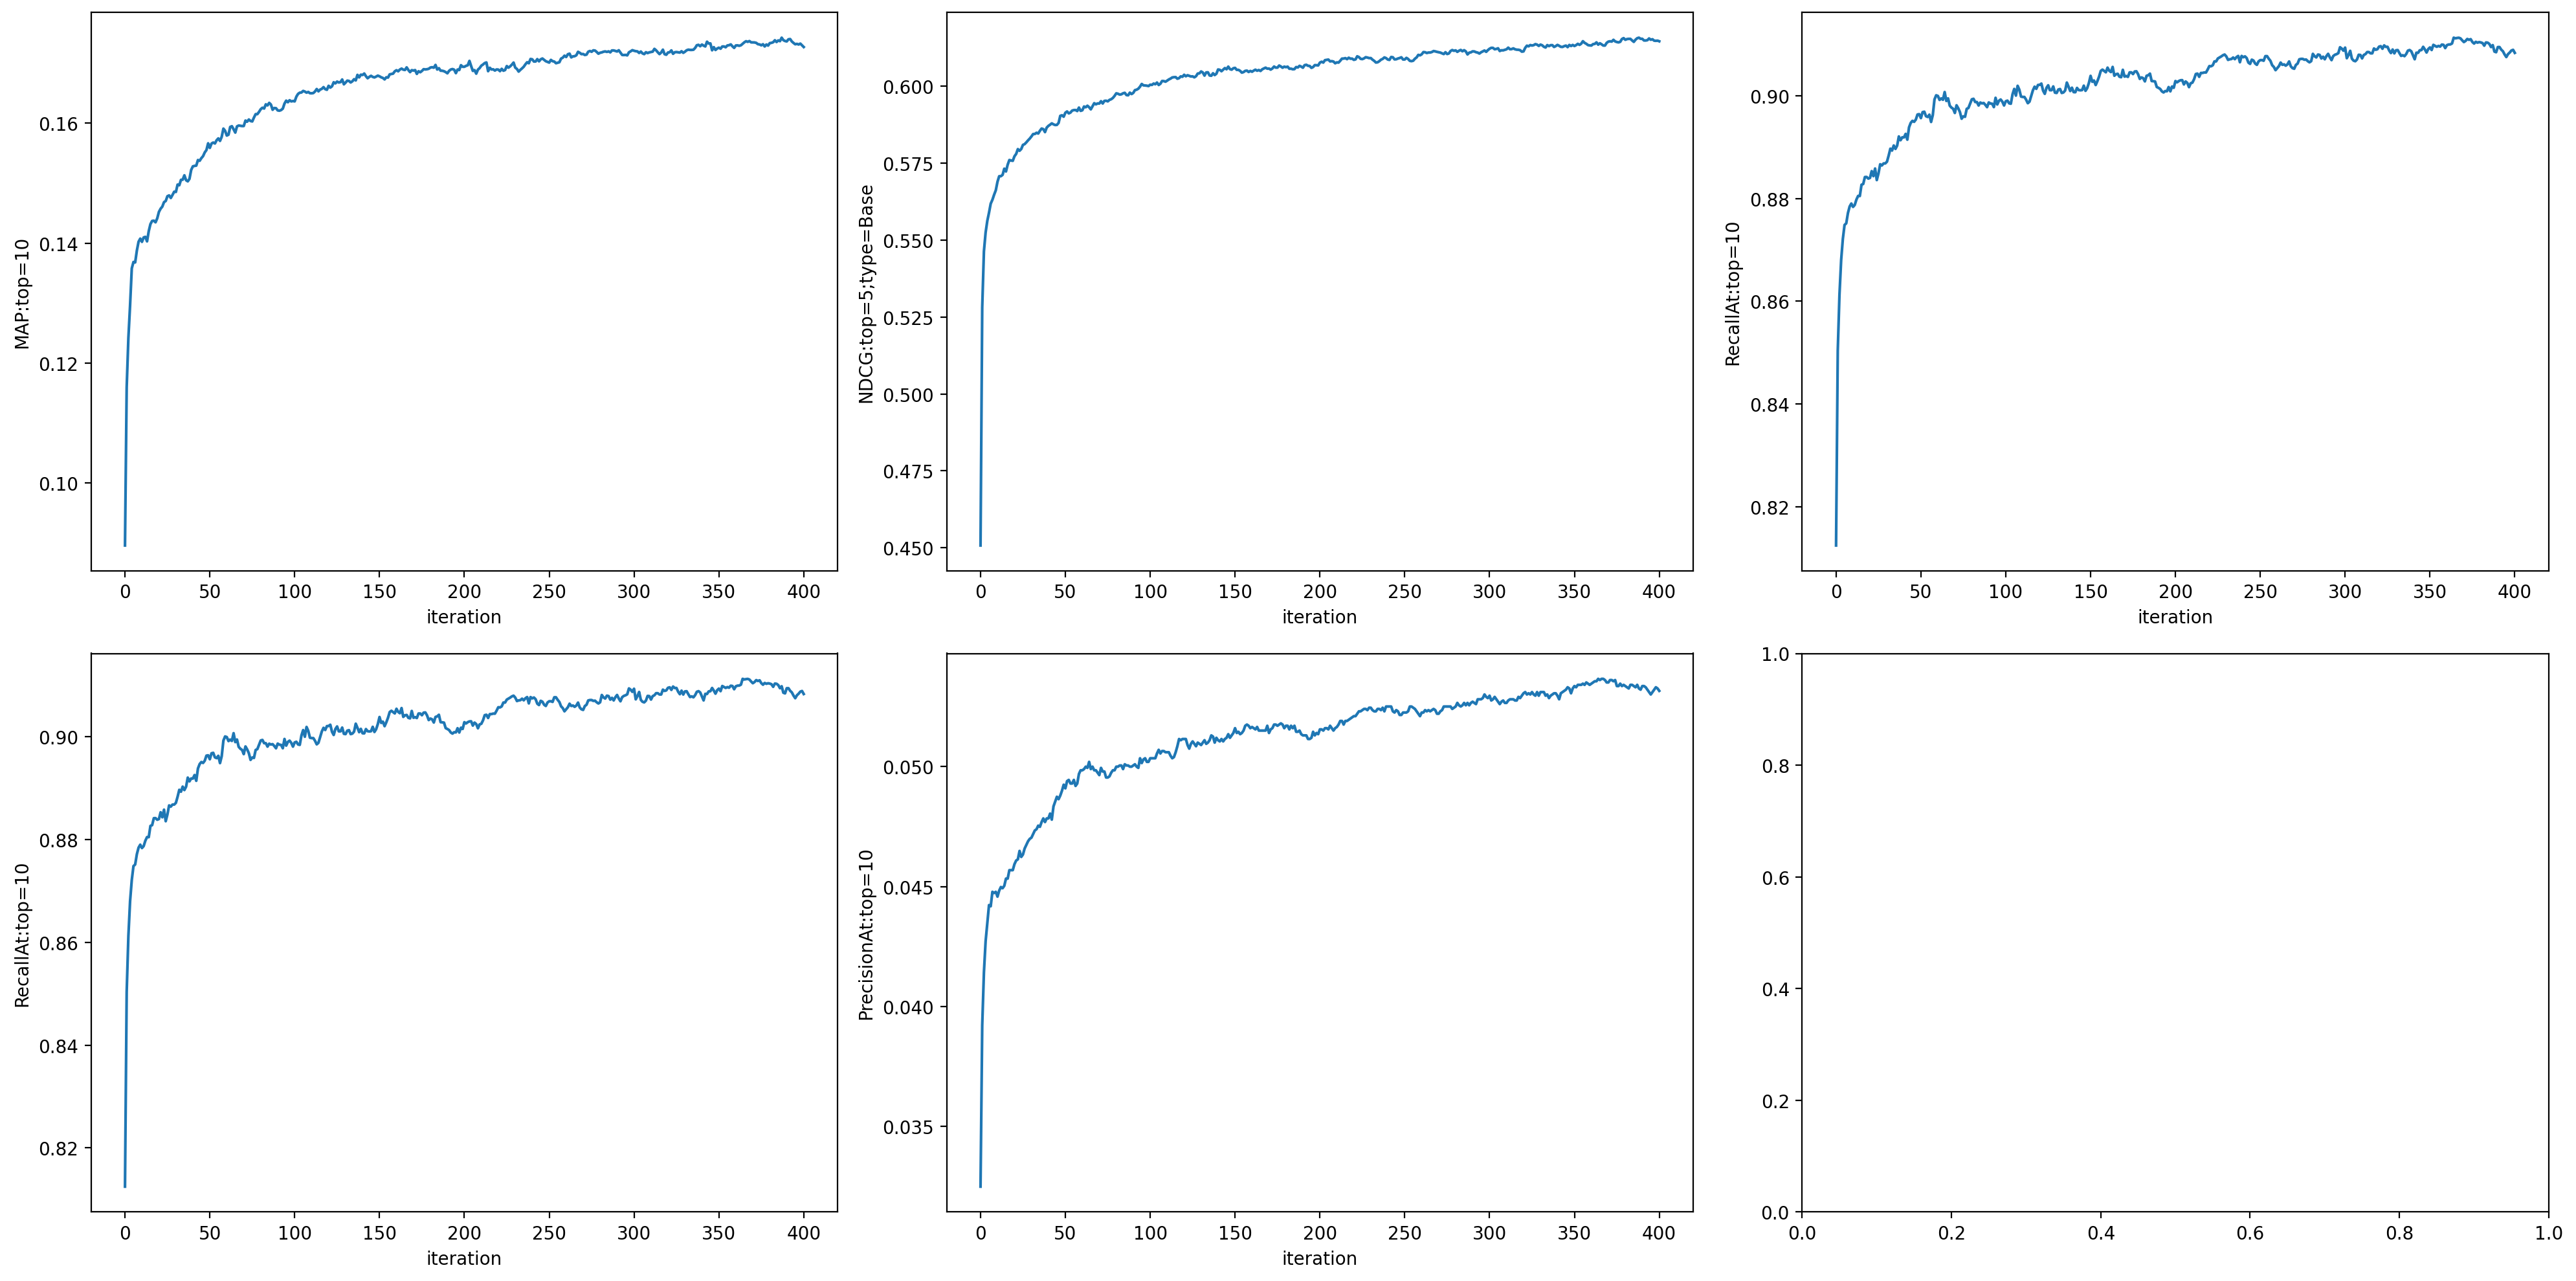

In [13]:
plot_results(model)

In [14]:
model = fit_model('QueryRMSE', {'custom_metric': ['NDCG:top=5', 'PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

Default metric period is 5 because PrecisionAt, RecallAt, MAP, NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


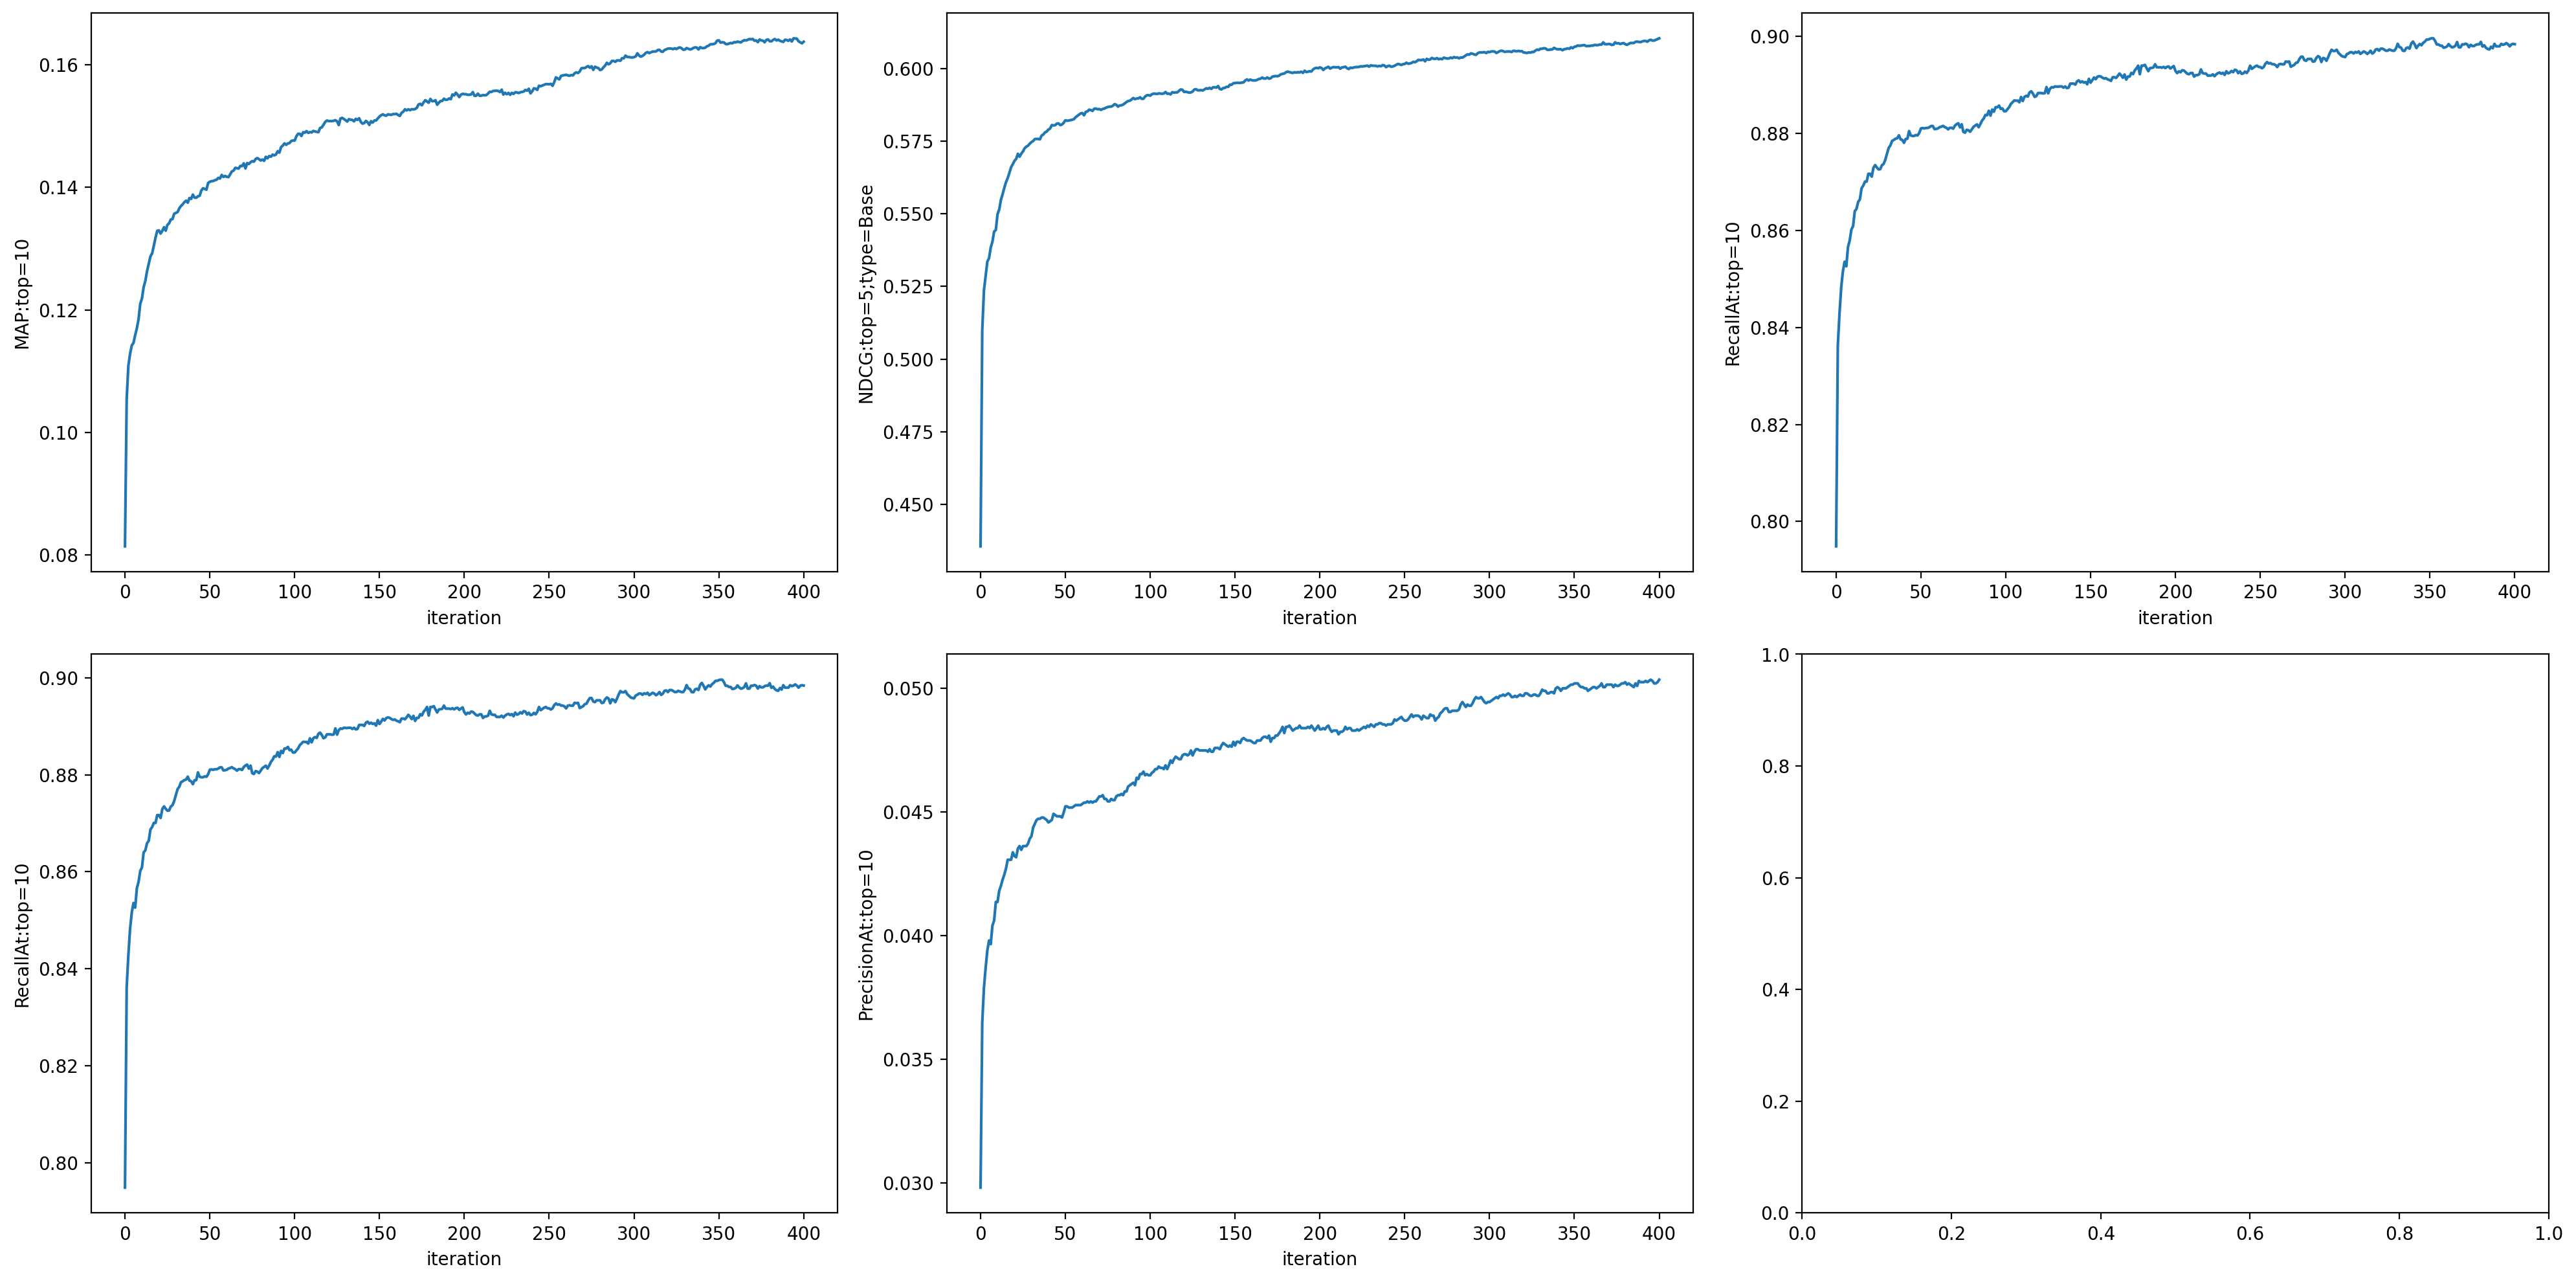

In [15]:
plot_results(model)

In [16]:
model = fit_model('PairLogit:max_pairs=10000', {'custom_metric': ['NDCG:top=5', 'PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

Default metric period is 5 because PrecisionAt, RecallAt, MAP, NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


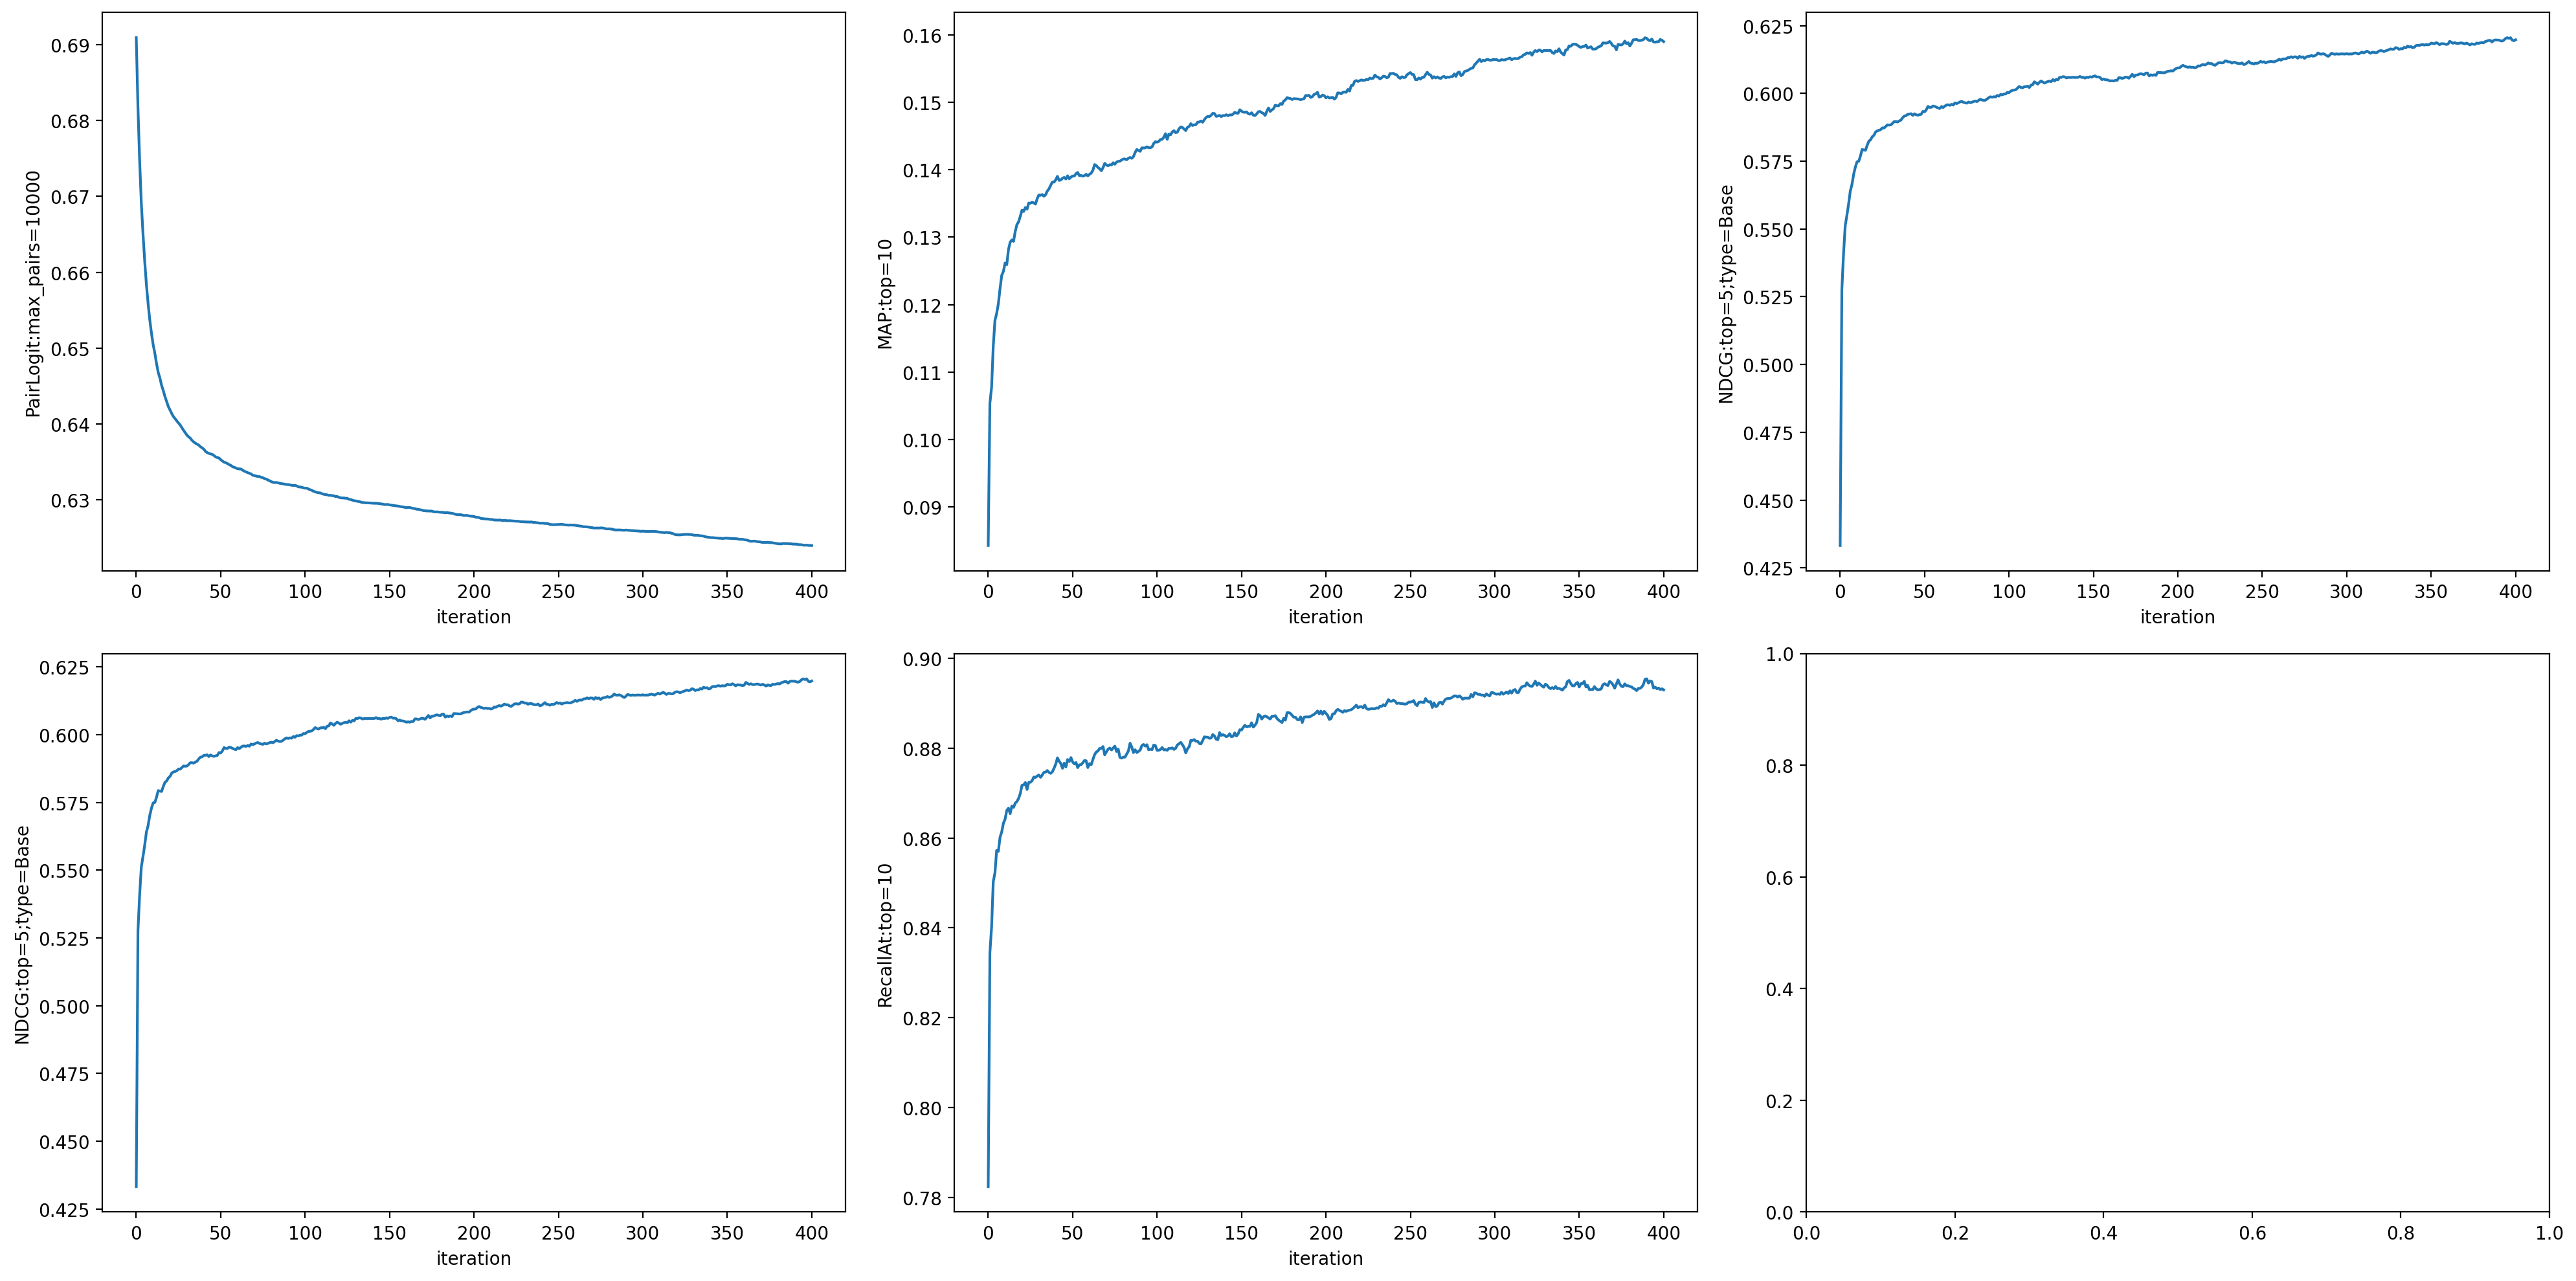

In [17]:
plot_results(model)

In [18]:
model = fit_model('PairLogitPairwise:max_pairs=10000', {'custom_metric': ['NDCG:top=5', 'PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

Default metric period is 5 because PrecisionAt, RecallAt, MAP, NDCG is/are not implemented for GPU
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


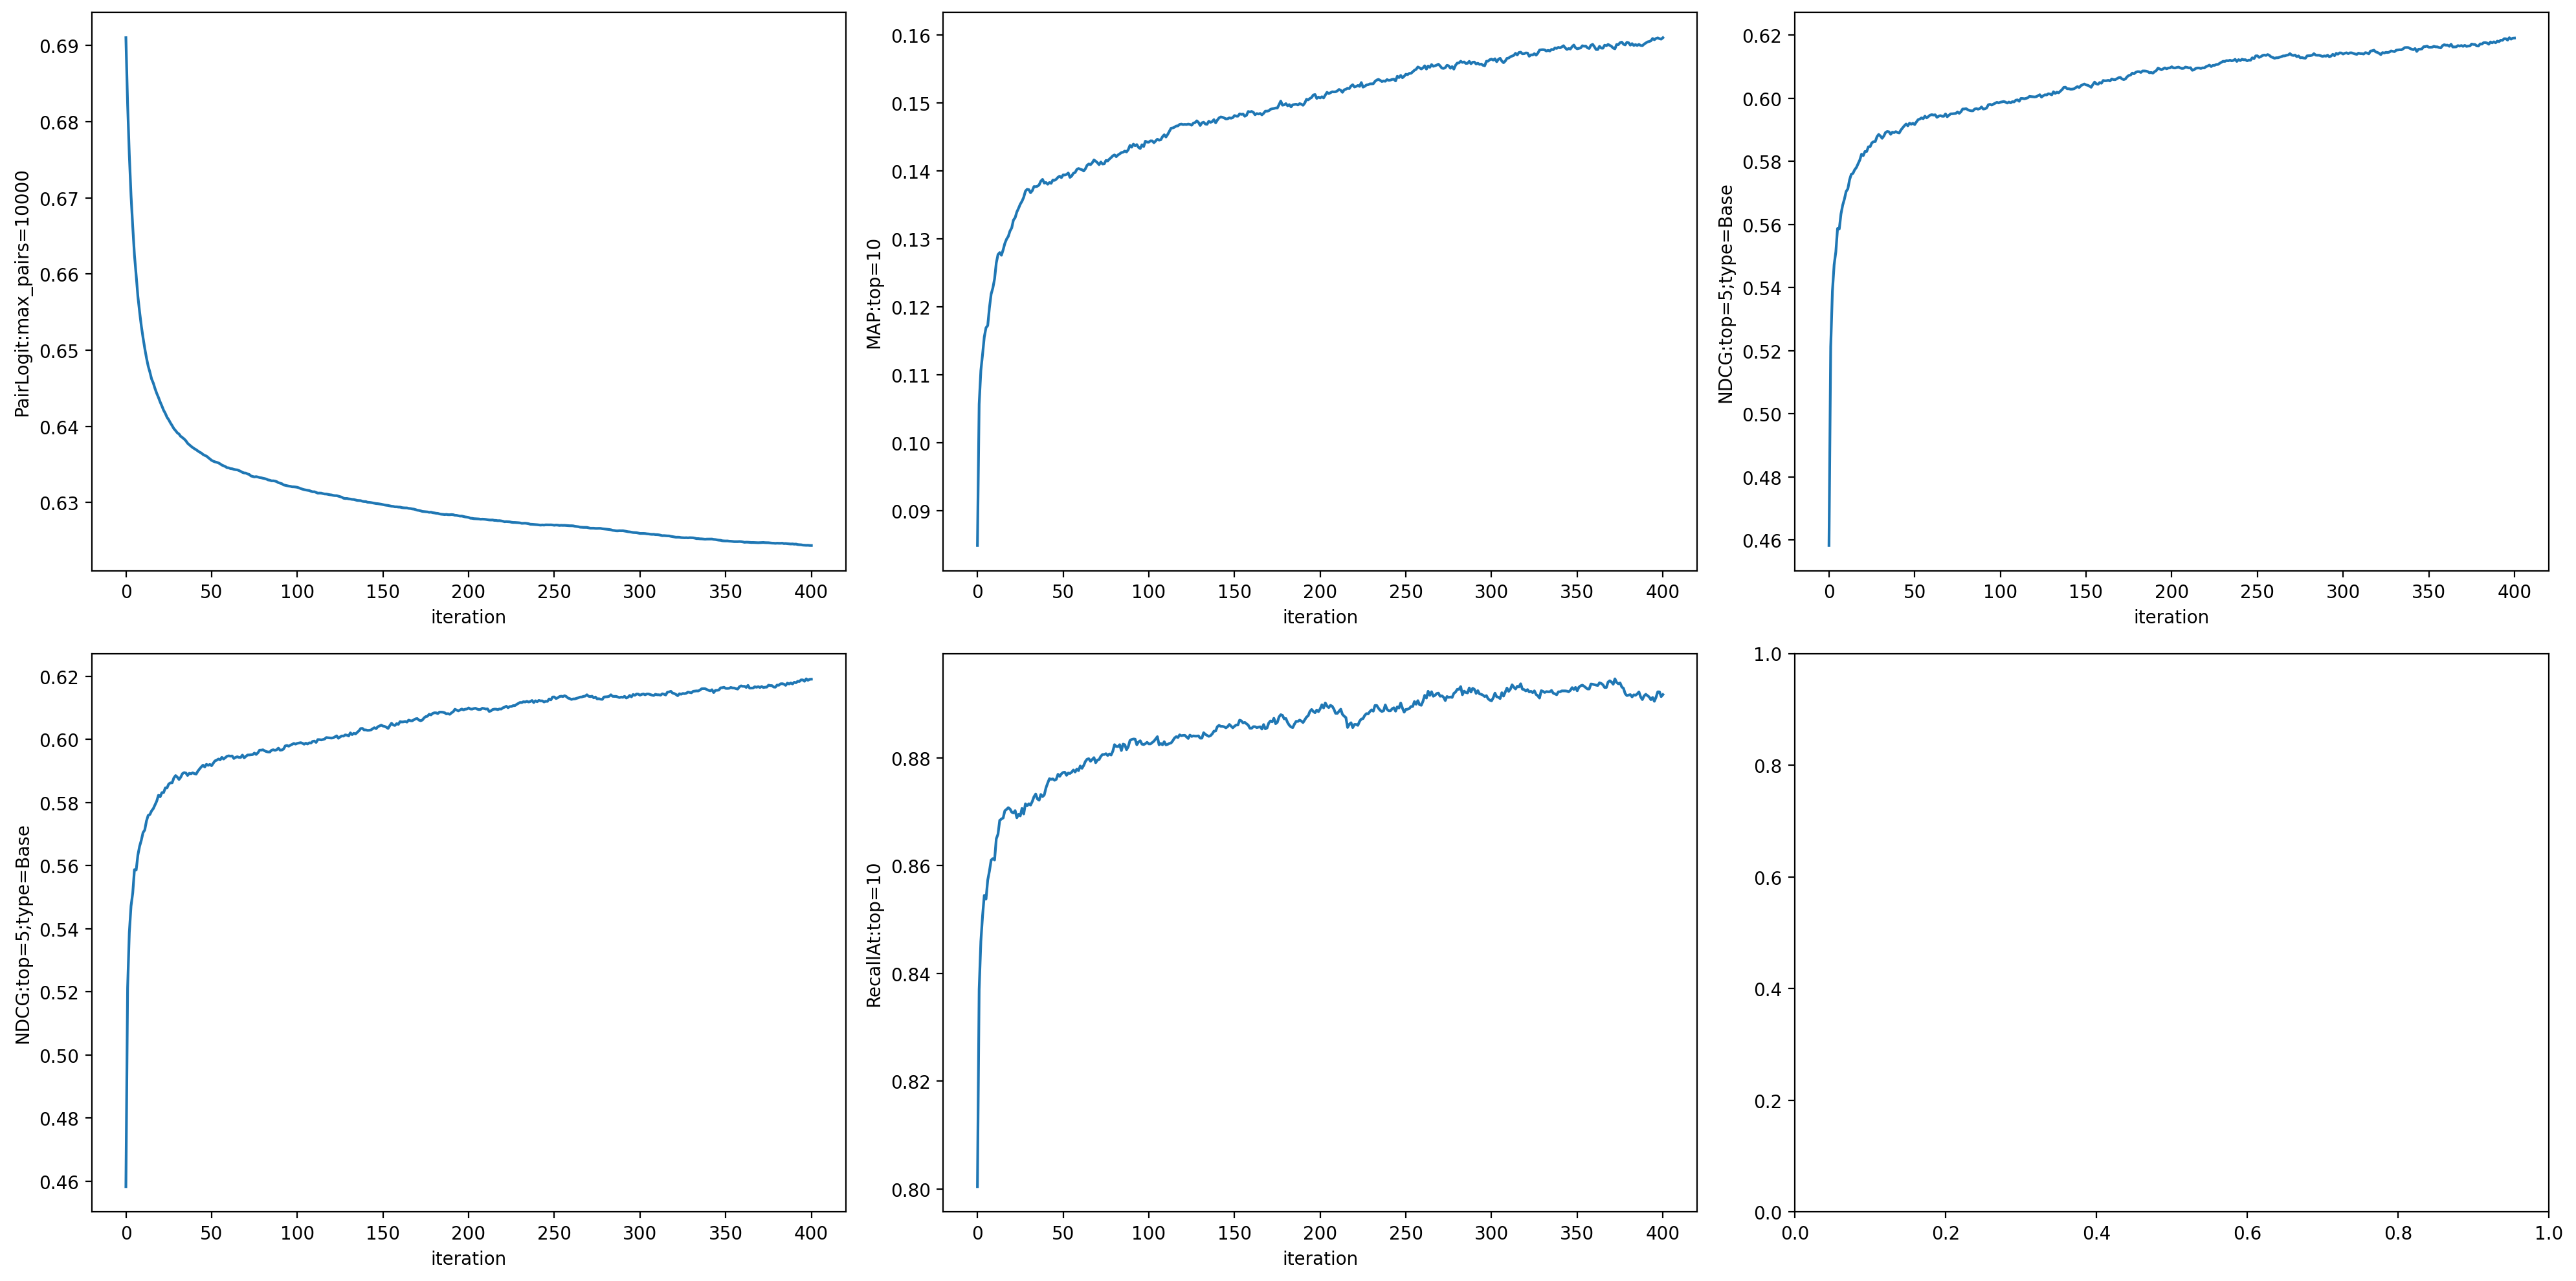

In [19]:
plot_results(model)

In [20]:
model = fit_model('YetiRankPairwise:max_pairs=10000', {'custom_metric': ['NDCG:top=5', 'PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})

Default metric period is 5 because PFound, PrecisionAt, RecallAt, MAP, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=5;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


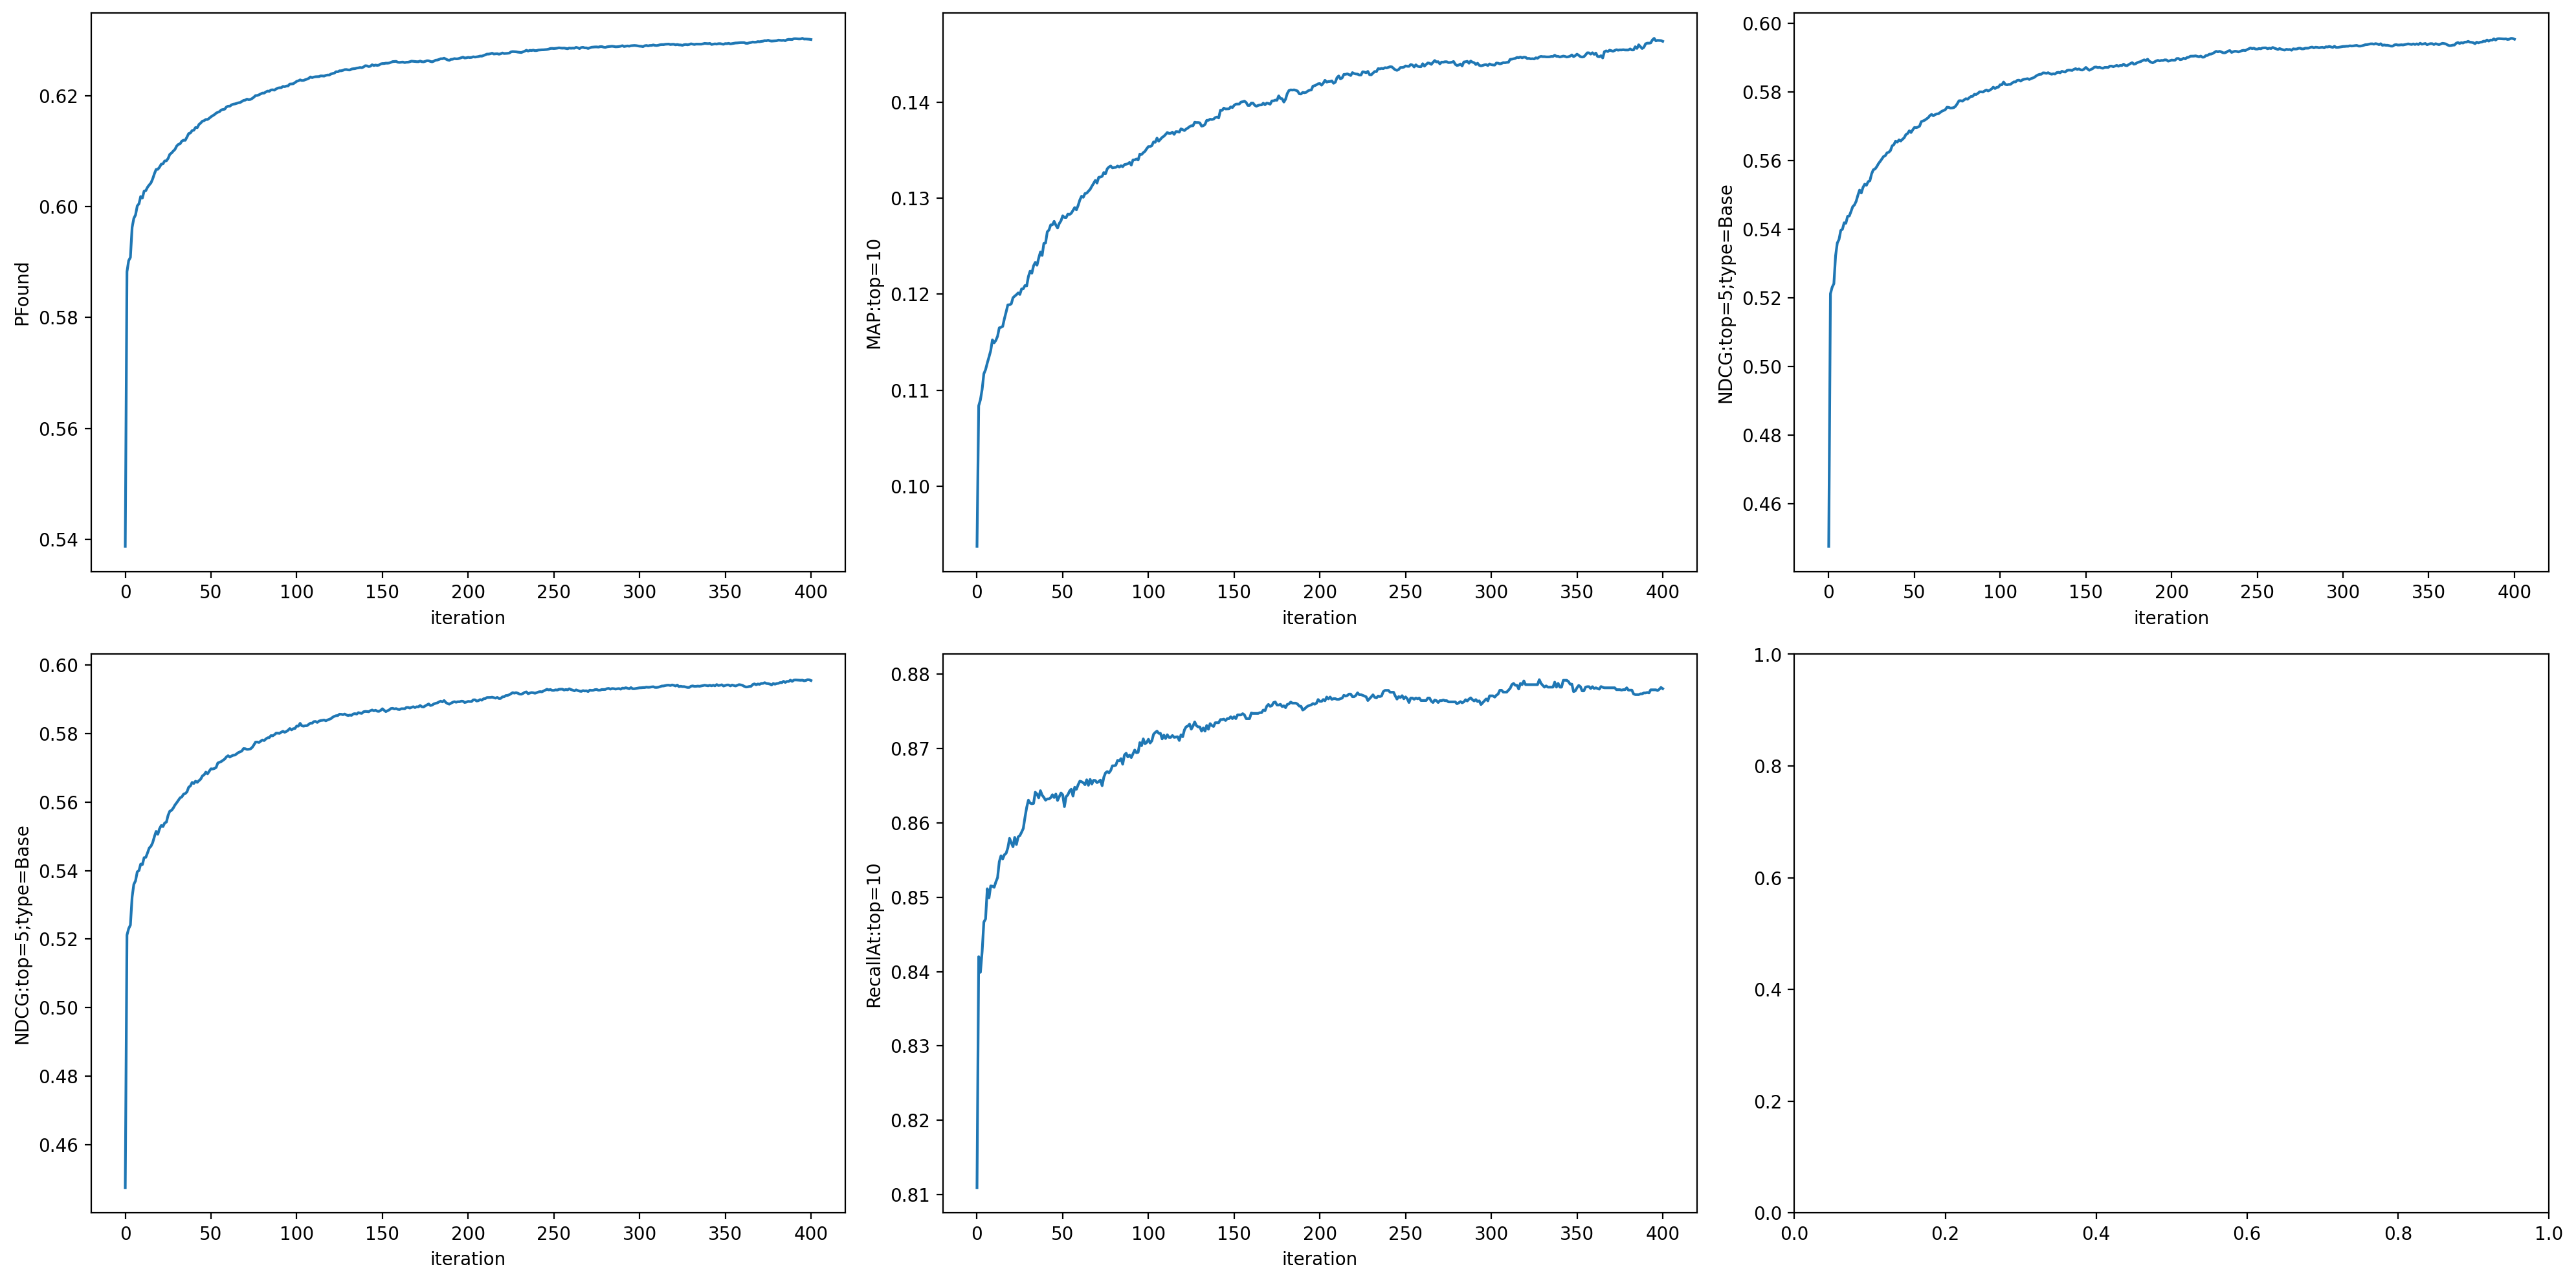

In [21]:
plot_results(model)